## Script to save images of trajectories and objectives of each dam
Image for example
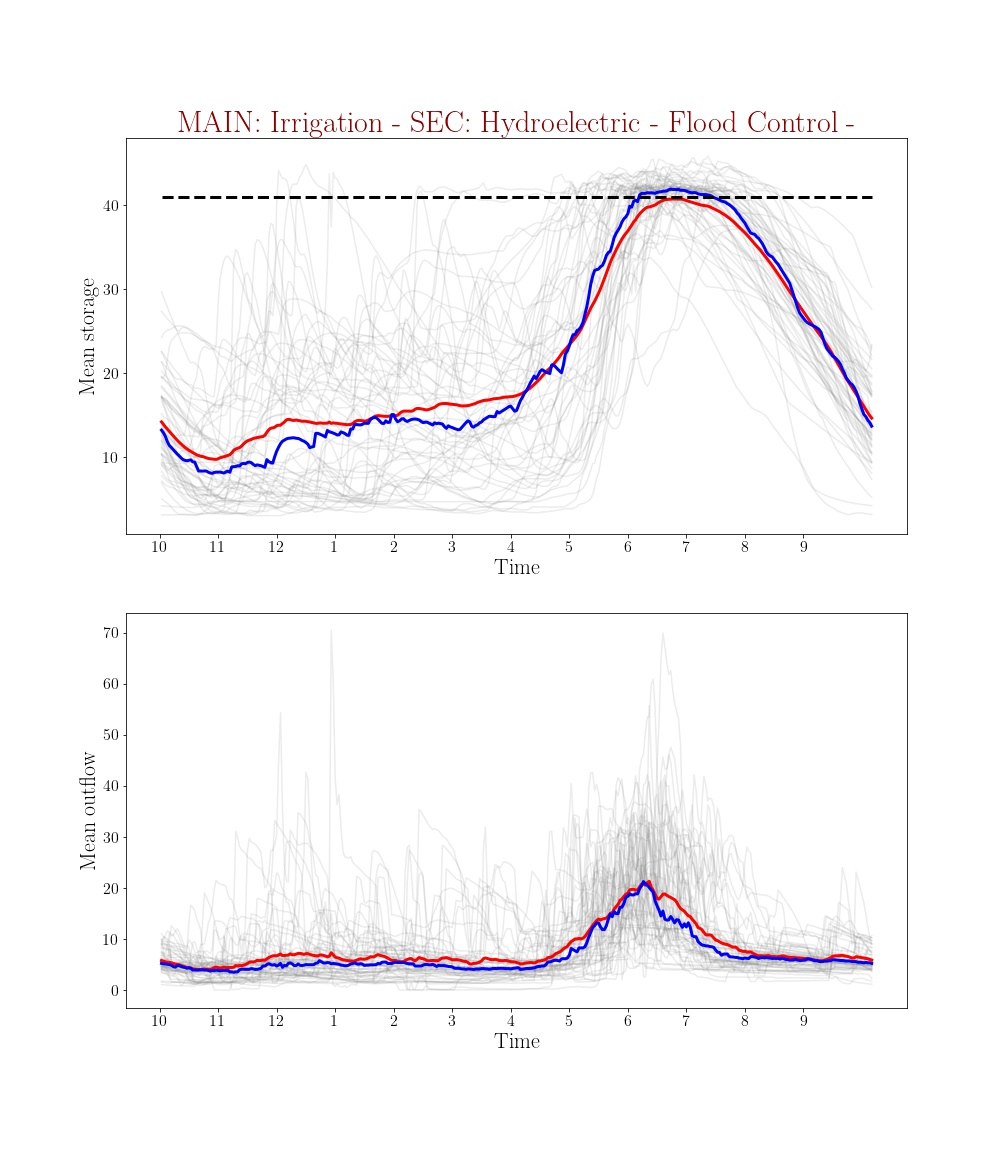

In [1]:
import csv
import pandas as pd
import numpy as np
import sklearn
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as MT
import matplotlib.lines as L
import matplotlib.cm as CM
from matplotlib import cm
import matplotlib.colors as C
import matplotlib.patches as PA
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import pickle 
from tol_colors import tol_cmap
import calendar
import os
import shutil
from datetime import datetime, timedelta

plt.close('all')
plt.style.use('default')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 14})
start = 0.0
stop = 1.0
number_of_lines= 10
cm_subsection = np.linspace(start, stop, number_of_lines) 
colors = [ cm.hsv(x) for x in cm_subsection ]

cmap = tol_cmap('rainbow_discrete', 10)
colors = cmap(1.0)
colors = [ cmap(x) for x in cm_subsection ]


LEGEND_FONT_SIZE = 22
AXIS_FONT_SIZE = 22
TICKS_FONT_SIZE = 16
LINE_WIDTH = 3.0


In [136]:
def switch_obj(_str):
    if _str == "USE_IRRI,C,5":
        _str = "Irrigation"
    if _str == "USE_ELEC,C,5":
        _str = "Hydroelectric"
    if _str == "USE_SUPP,C,5":
        _str = "Water Supply"
    if _str == "USE_FCON,C,5":
        _str = "Flood Control"
    if _str == "USE_RECR,C,5":
        _str = "Recreation"
    return _str

def save_med_mean_double(attr1, attr2, data, max_storage, PATH, main, sec, q75 = None, q25 = None):

    %matplotlib inline

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14,16))
    
    
    font = {'family': 'sans-serif',
        'color':  'darkred',
        'weight': 'heavy',
        'size': 30,
        }
    ax1.set_title("MAIN: " + main + "   -   SEC: " + sec, fontdict = font)
    ax1.set_xlabel('Time', fontsize=AXIS_FONT_SIZE)
    ax1.set_ylabel('Mean '+ attr1.replace("_", " "), fontsize=AXIS_FONT_SIZE)
    ax1.tick_params(labelsize=TICKS_FONT_SIZE)

    start_year = data["water_year"].iloc[0] 
    end_year = data["water_year"].iloc[-1]


    for i,y in enumerate(range(start_year, end_year + 1)):
        ax1.plot(data[(data['water_year'] == y)]["n_day_water"] ,data[(data['water_year'] == y)][attr1], c = "gray", alpha = 0.15)
        
    mean_= data.groupby('n_day_water').mean()[attr1].values
    median_= data.groupby('n_day_water').median()[attr1].values

    ax1.plot(range(1,366,1), mean_, c = "r", linewidth = 3)
    ax1.plot(range(1,366,1), median_, c = "b", linewidth = 3)
    if q75 is not None and q25 is not None:
        plt.fill_between(range(1,366,1), q25, q75, alpha=0.4)
        #plt.plot(range(1,366,1), q75, "--", c = "k", linewidth = 2)
        #plt.plot(range(1,366,1), q25, "--", c = "k", linewidth = 2)
        
    if attr1 == "storage":
        ax1.plot(range(1,366,1), np.tile(max_storage,365), "--", c = "k", linewidth = 3)

    ax1.set_xticks(np.arange(0,360,30))
    ax1.set_xticklabels(uniq)
    
    ####
    
    ax2.set_xlabel('Time', fontsize=AXIS_FONT_SIZE)
    ax2.set_ylabel('Mean '+ attr2.replace("_", " "), fontsize=AXIS_FONT_SIZE)
    ax2.tick_params(labelsize=TICKS_FONT_SIZE)

    start_year = data["water_year"].iloc[0] 
    #end_year = start_year + 15
    end_year = data["water_year"].iloc[-1]


    for i,y in enumerate(range(start_year, end_year + 1)):
        ax2.plot(data[(data['water_year'] == y)]["n_day_water"] ,data[(data['water_year'] == y)][attr2], c = "gray", alpha = 0.15)
        
    mean_= data.groupby('n_day_water').mean()[attr2].values
    median_= data.groupby('n_day_water').median()[attr2].values

    ax2.plot(range(1,366,1), mean_, c = "r", linewidth = 3)
    ax2.plot(range(1,366,1), median_, c = "b", linewidth = 3)
    if q75 is not None and q25 is not None:
        plt.fill_between(range(1,366,1), q25, q75, alpha=0.4)
        #plt.plot(range(1,366,1), q75, "--", c = "k", linewidth = 2)
        #plt.plot(range(1,366,1), q25, "--", c = "k", linewidth = 2)
        
    if attr2 == "storage":
        plt.plot(range(1,366,1), np.tile(max_storage,365), "--", c = "k", linewidth = 3)

    ax2.set_xticks(np.arange(0,360,30))
    ax2.set_xticklabels(uniq)

    plt.savefig(PATH)

In [152]:
def save_id(_id):
    dataset_number = _id

    base_dir = '../ResOpsUS/data/' + str(dataset_number) + "/"
    logs_dir = '../logs/ResOpsUS/' + str(dataset_number) + "/"

    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

    if not os.path.exists(logs_dir):
        os.makedirs(logs_dir)

    data = pd.read_csv('../ResOpsUS/time_series/' + "ResOpsUS_" + str(dataset_number) + ".csv", delimiter=',')

    data = data[["date", "outflow", "storage", "water_year"]]
    data['date'] = pd.to_datetime(data['date'])
    data['day'] = data['date'].dt.day
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year
    data["hydro"] = data['storage'].values * data['outflow'].values
    #data.drop(["date"], axis = 1)

    start_year = data['water_year'].iloc[0]
    end_year = data['water_year'].iloc[-1]

    data["n_day"] = np.zeros(len(data["date"]))

    for i in range(len(data["date"])):
        if calendar.isleap(data["date"].iloc[i].year) and data["date"].iloc[i].timetuple().tm_yday > 59: 
            data["n_day"].iloc[i] = data["date"].iloc[i].timetuple().tm_yday - 1
        else:
            data["n_day"].iloc[i] = data["date"].iloc[i].timetuple().tm_yday

    data["n_day_water"] = data["n_day"]

    data.loc[(data['month'] == 10) | (data['month'] == 11) | (data['month'] == 12), "n_day_water"] -= 273 
    data.loc[(data['month'] != 10) & (data['month'] != 11) & (data['month'] != 12), "n_day_water"] += (365 - 273) 
    
    objs = G.iloc[dataset_number - 1][["USE_IRRI,C,5", "USE_ELEC,C,5",  "USE_SUPP,C,5", "USE_FCON,C,5", "USE_RECR,C,5"]]

    main = objs[objs == "Main"].keys().values.tolist()[0]
    main = switch_obj(main)

    sec = ""
    sec_vec = objs[objs == "Sec"].keys().values.tolist()

    for obj in sec_vec:
        sec += (switch_obj(obj) + " - ")

    max_storage = int(G.iloc[dataset_number - 1]["NEW_STORAGE"])

    save_med_mean_double("storage", "outflow", data, max_storage, PATH = _dir + "/" + str(_id) + ".jpg", main = main, sec = sec)
    


In [22]:
G = pd.read_excel("../ResOpsUS/GRanD_dams_v1_3.xls")
main_dir = '../ResOpsUS/time_series/'

all_id = []
for file in os.listdir(main_dir):
    all_id.append(int(re.search("\d+",file).group(0)))

## IRRIGATION ONLY


In [132]:
irrigation_only = G[(G["USE_IRRI,C,5"] == "Main") & (G["USE_ELEC,C,5"].isnull()) & (G["USE_SUPP,C,5"].isnull()) & 
                    (G["USE_FCON,C,5"].isnull()) & (G["USE_RECR,C,5"].isnull())]

grand_id = irrigation_only["GRAND_ID,N,5,0"]
valid_id = np.intersect1d(np.array(all_id), grand_id)

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

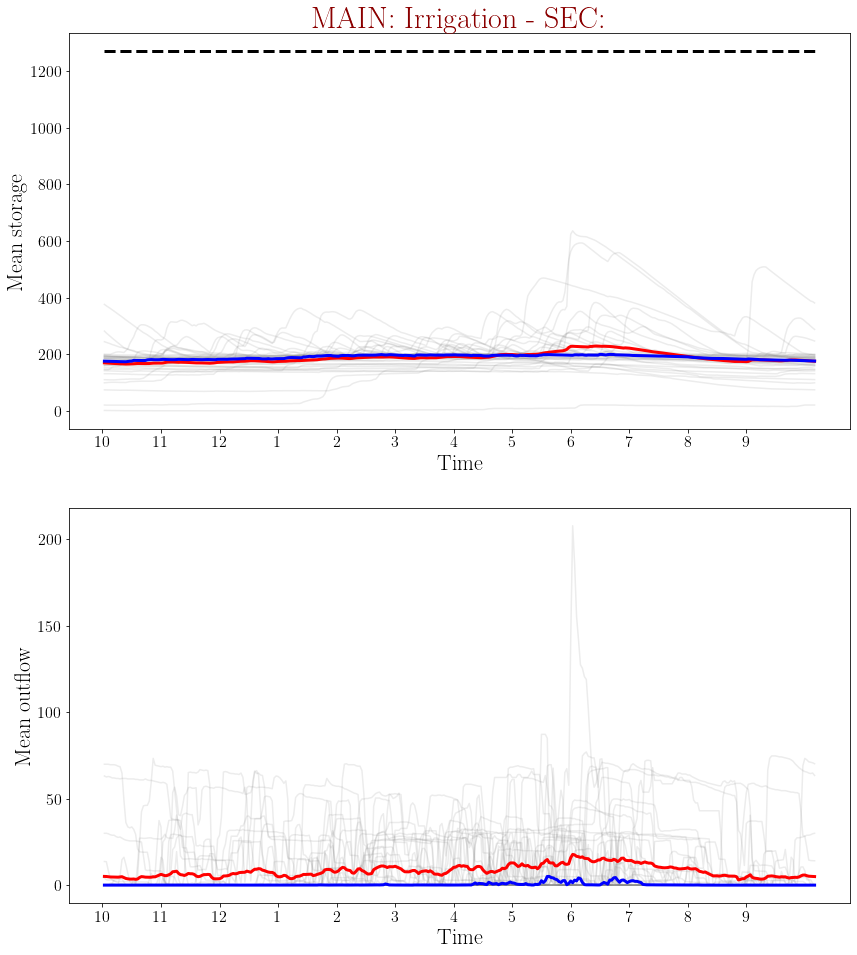

In [137]:
_dir = os.path.join('../ResOpsUS/Images/',"irrigation_only")
if not os.path.exists(_dir):
    os.makedirs(_dir)
    
for _id in valid_id:
    save_id(int(_id))
    

## IRRIGATION ALL

In [149]:
irrigation_all = G[(G["USE_IRRI,C,5"] == "Main")]

grand_id = irrigation_all["GRAND_ID,N,5,0"]
valid_id = np.intersect1d(np.array(all_id), grand_id)

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

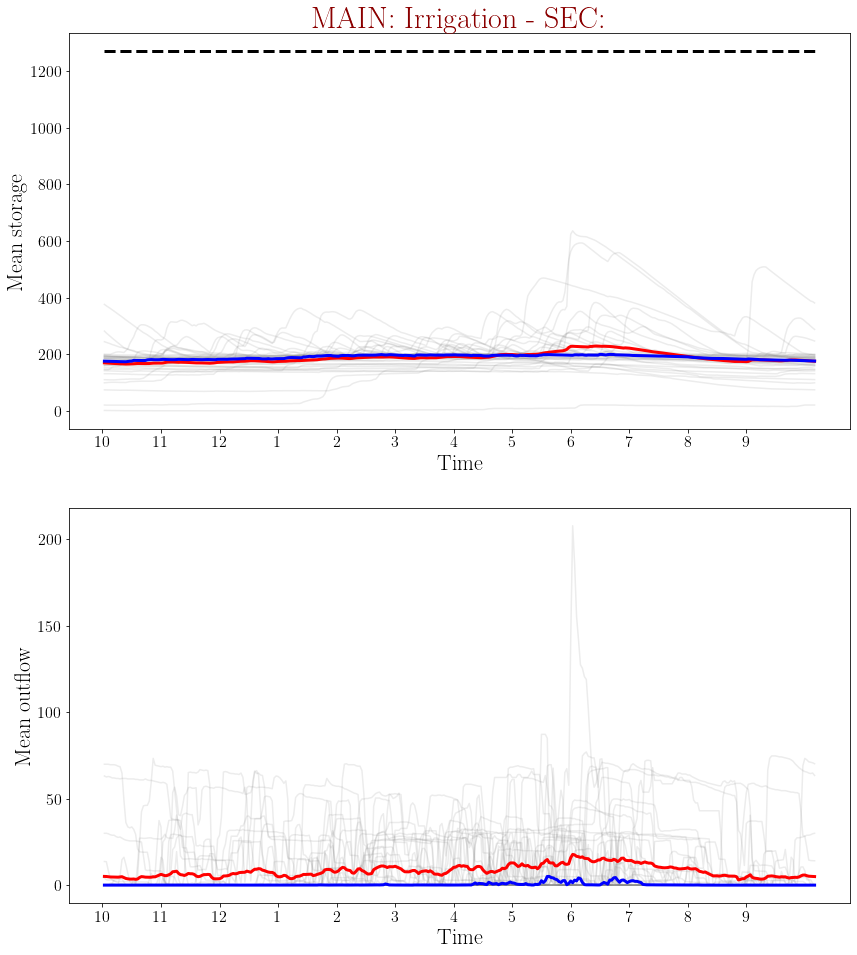

In [153]:
_dir = os.path.join('../ResOpsUS/Images/',"irrigation_all")
if not os.path.exists(_dir):
    os.makedirs(_dir)
    
for _id in valid_id:
    save_id(int(_id))

## HYDROELECTRIC ONLY

In [156]:
hydro_only = G[(G["USE_IRRI,C,5"].isnull()) & (G["USE_ELEC,C,5"] == "Main") & (G["USE_SUPP,C,5"].isnull()) & 
                    (G["USE_FCON,C,5"].isnull())]

grand_id = hydro_only["GRAND_ID,N,5,0"]
valid_id = np.intersect1d(np.array(all_id), grand_id)

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

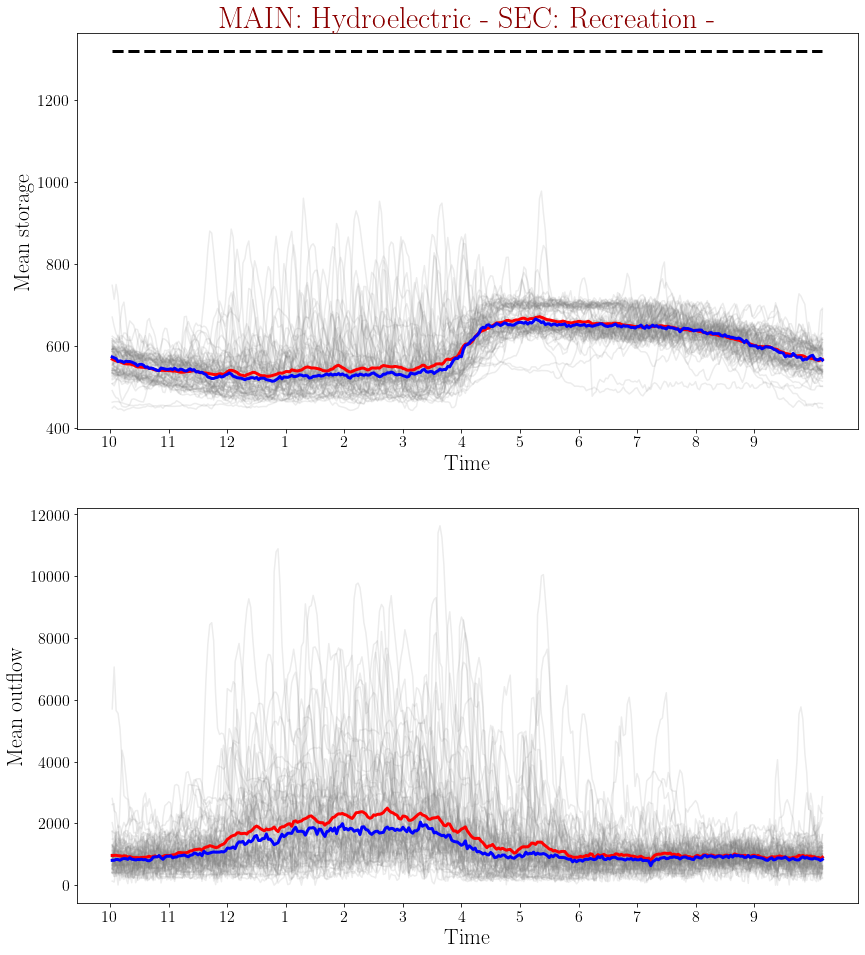

In [157]:
_dir = os.path.join('../ResOpsUS/Images/',"hydro_only")
if not os.path.exists(_dir):
    os.makedirs(_dir)
    
for _id in valid_id:
    save_id(int(_id))
    

## HYDROELECTRIC ALL

In [158]:
hydro_all = G[(G["USE_ELEC,C,5"] == "Main")]

grand_id = hydro_all["GRAND_ID,N,5,0"]
valid_id = np.intersect1d(np.array(all_id), grand_id)

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

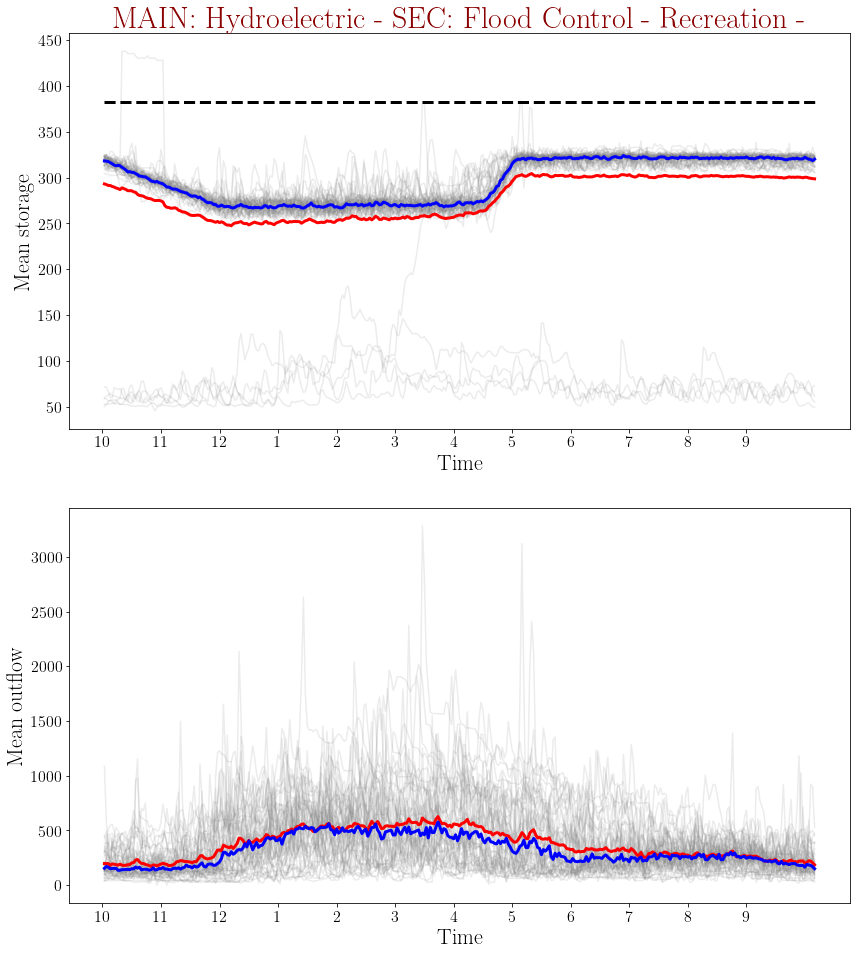

In [159]:
_dir = os.path.join('../ResOpsUS/Images/',"hydro_all")
if not os.path.exists(_dir):
    os.makedirs(_dir)
    
for _id in valid_id:
    save_id(int(_id))
    

## WATER SUPPLY ONLY

In [160]:
supply_only = G[(G["USE_IRRI,C,5"].isnull()) & (G["USE_ELEC,C,5"].isnull()) & (G["USE_SUPP,C,5"] == "Main") & 
                    (G["USE_FCON,C,5"].isnull())]

grand_id = supply_only["GRAND_ID,N,5,0"]
valid_id = np.intersect1d(np.array(all_id), grand_id)

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

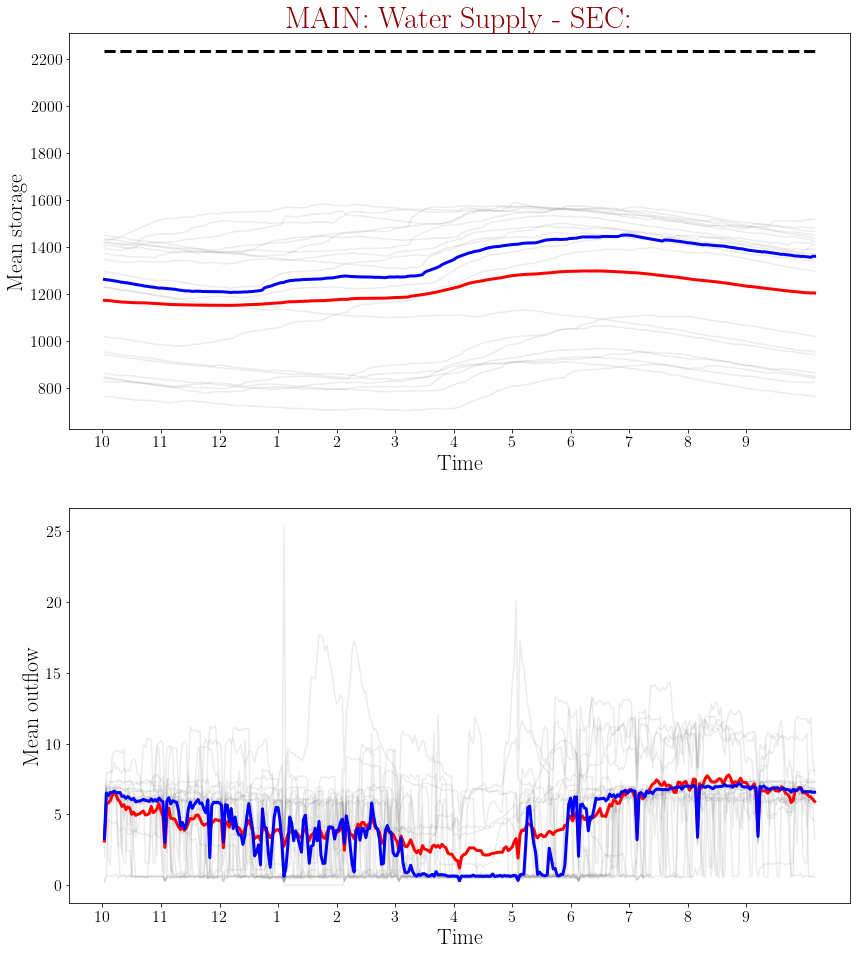

In [161]:
_dir = os.path.join('../ResOpsUS/Images/',"supply_only")
if not os.path.exists(_dir):
    os.makedirs(_dir)
    
for _id in valid_id:
    save_id(int(_id))
    

## WATER SUPPLY ALL

In [162]:
supply_all = G[(G["USE_SUPP,C,5"] == "Main")]

grand_id = supply_all["GRAND_ID,N,5,0"]
valid_id = np.intersect1d(np.array(all_id), grand_id)

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

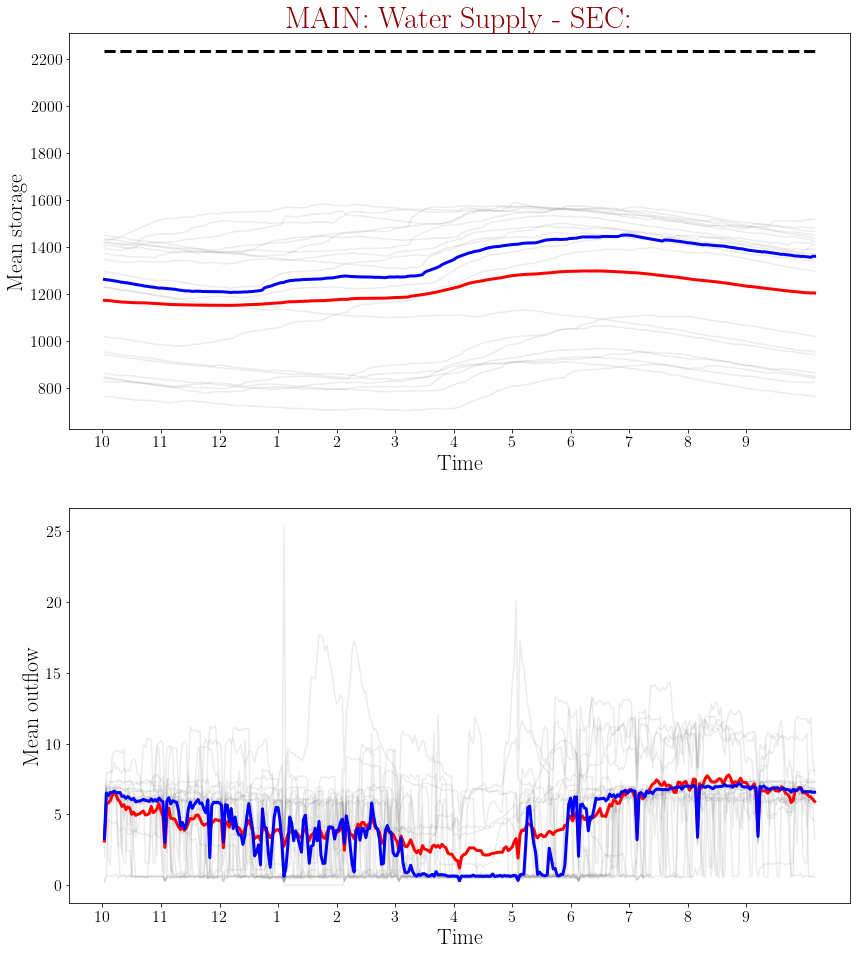

In [163]:
_dir = os.path.join('../ResOpsUS/Images/',"supply_all")
if not os.path.exists(_dir):
    os.makedirs(_dir)
    
for _id in valid_id:
    save_id(int(_id))
    

## FLOOD CONTROL ONLY

In [164]:
flood_only = G[(G["USE_IRRI,C,5"].isnull()) & (G["USE_ELEC,C,5"].isnull()) & (G["USE_SUPP,C,5"].isnull()) & 
                    (G["USE_FCON,C,5"] == "Main")]

grand_id = flood_only["GRAND_ID,N,5,0"]
valid_id = np.intersect1d(np.array(all_id), grand_id)

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

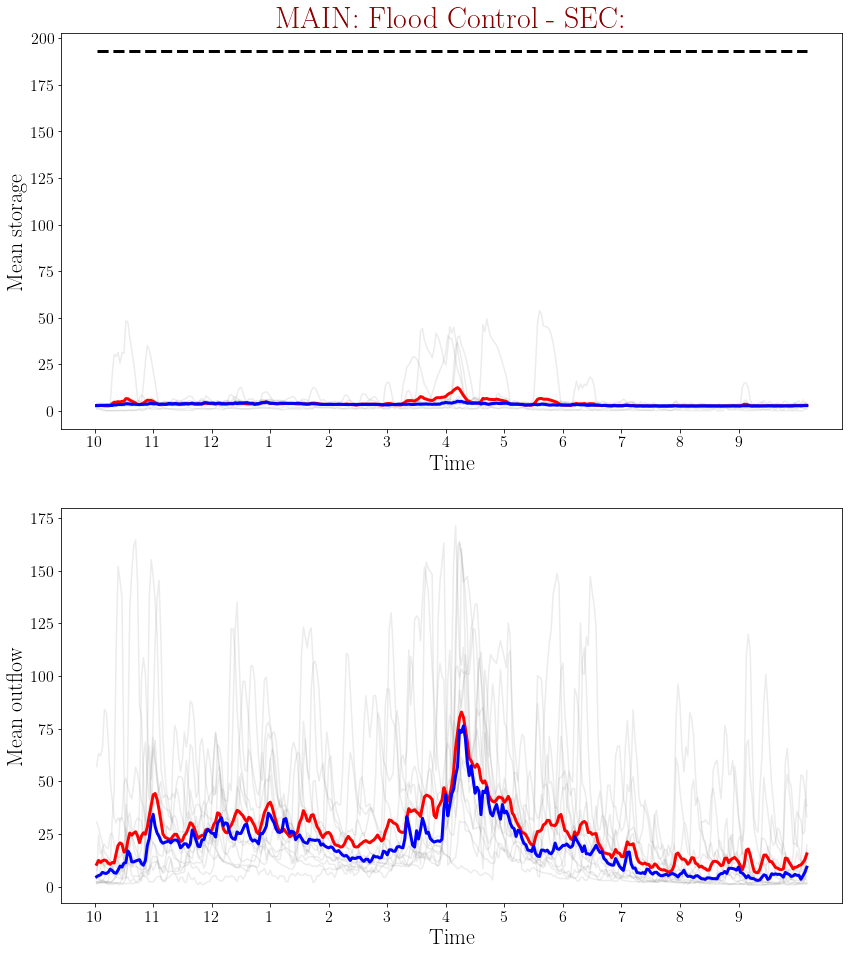

In [165]:
_dir = os.path.join('../ResOpsUS/Images/',"flood_only")
if not os.path.exists(_dir):
    os.makedirs(_dir)
    
for _id in valid_id:
    save_id(int(_id))
    

## FLOOD CONTROL ALL

In [166]:
flood_all = G[(G["USE_FCON,C,5"] == "Main")]

grand_id = flood_all["GRAND_ID,N,5,0"]
valid_id = np.intersect1d(np.array(all_id), grand_id)

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Manuel/.virtualenvs/irl_real_life/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

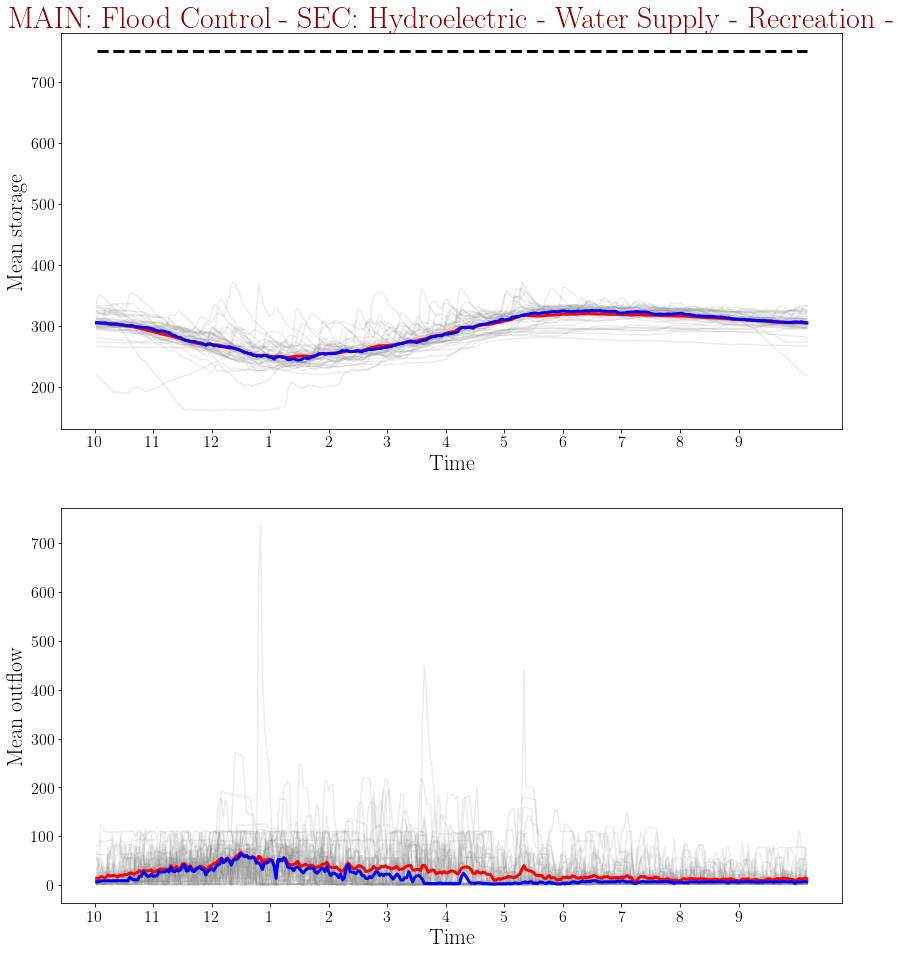

In [167]:
_dir = os.path.join('../ResOpsUS/Images/',"flood_all")
if not os.path.exists(_dir):
    os.makedirs(_dir)
    
for _id in valid_id:
    save_id(int(_id))
    